### Support Vector Machines (SVM) – Intro & Regression

* SVM is a supervised learning algorithm used for classification, regression, and outlier detection.

* It works well on complex and high-dimensional datasets.

* Kernels (linear, polynomial, RBF, sigmoid) allow SVM to handle both linear and non-linear data.

* Core idea: SVM finds the best boundary (margin) between classes. The data points closest to this boundary are called support vectors.

* While SVMs are mostly known for classification, they can also be applied to regression (Support Vector Regression - SVR).

👉 In this notebook, I start with SVM for regression (using the same dataset as linear regression) to compare performance.

Contents:

1. Imports
2. Loading the Data
3. Exploratory Data Analysis
4. Data preprocessing
5. Training Support Vector Regressor
6. Evaluating Support Vector Regressor
7. Improving Support Vector Regressor

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 2. Loading the Data

In [2]:
cal_data = pd.read_csv('/content/housing.csv')
cal_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
len(cal_data)

20640

# 3. Exploratory Data Analysis

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(cal_data, test_size=0.1, random_state=101)

print("The size of the train data is: {}\nThe size of the test data is: {}".format(len(train_data), len(test_data)))

The size of the train data is: 18576
The size of the test data is: 2064


In [5]:
# checking statistics
train_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18576.000000,18576.000000,18576.000000,18576.000000,18387.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,-119.570116,35.634283,28.597599,2636.200474,538.450318,1426.219369,499.932063,3.865016,206557.539244
std,2.001859,2.137006,12.569833,2189.160135,424.197484,1139.155375,384.765575,1.892979,115302.391135
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,787.000000,279.000000,2.562500,119200.000000
50%,-118.500000,34.260000,29.000000,2126.500000,435.000000,1166.000000,409.000000,3.531750,179300.000000
75%,-118.010000,37.710000,37.000000,3152.250000,647.500000,1724.000000,605.000000,4.743700,264525.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# checking missing values
train_data.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,189
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [7]:
# checking values in the categorical features

train_data['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,8192
INLAND,5933
NEAR OCEAN,2402
NEAR BAY,2044
ISLAND,5


<Axes: xlabel='ocean_proximity', ylabel='count'>

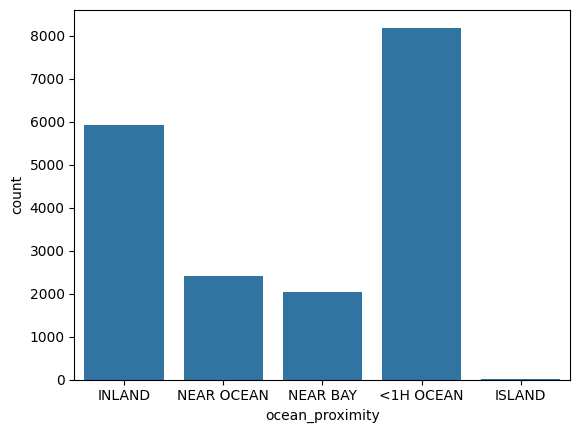

In [8]:
sns.countplot(data=train_data, x='ocean_proximity')

Total bedroom is the only feature having missing values. Here is its distribution.

<Axes: ylabel='Frequency'>

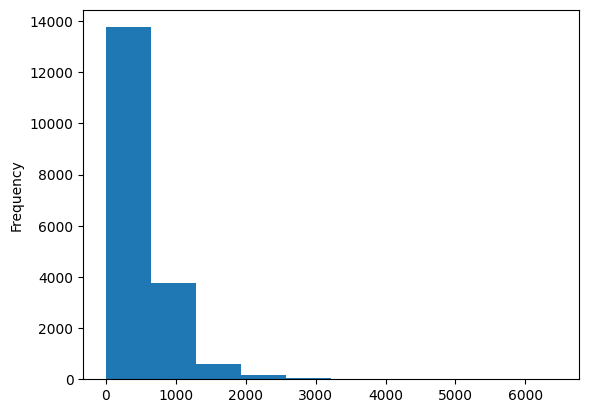

In [9]:
train_data['total_bedrooms'].plot(kind='hist')

<Axes: xlabel='longitude', ylabel='latitude'>

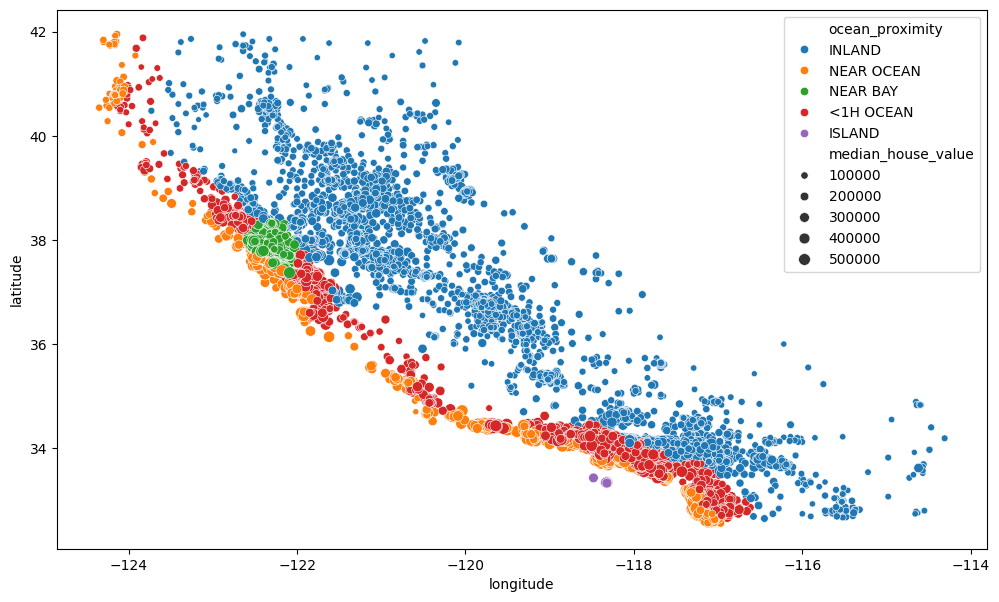

In [10]:
# plotting geographical features
plt.figure(figsize=(12,7))
sns.scatterplot(data=train_data, x='longitude', y='latitude', hue='ocean_proximity', size='median_house_value')

# 4. Data Preprocessing

In [11]:
# Spliting input (x) and target (y)
x_train = train_data.drop('median_house_value', axis=1)
y_train = train_data['median_house_value']

In [12]:
# Separating numerical and categorical features
numerical_features = x_train.drop('ocean_proximity', axis=1)
categorical_features = x_train[['ocean_proximity']]

In [13]:
# Numerical pipeline → filling missing + scale

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # fill NaN with mean
    ('scaler', StandardScaler())                   # scale to 0 mean, 1 std
])

In [14]:
# Combining both numerical and categorical

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

final_pipe = ColumnTransformer([
    ('num', numerical_pipeline, list(numerical_features)),      # apply pipeline to numeric
    ('cat', OneHotEncoder(), list(categorical_features))        # one-hot encode categorical
])

In [15]:
# Final preprocessed training data
x_train_preprocessed = final_pipe.fit_transform(x_train)
x_train_preprocessed

array([[-0.74926591,  1.63584512, -1.63869746, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22894872, -1.331002  , -1.00223592, ...,  0.        ,
         0.        ,  1.        ],
       [-1.34872488,  1.04153978,  1.86184103, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.09395482,  0.77948389, -1.79781285, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18886916,  0.80288173,  0.58891794, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97905851,  0.56890325, -0.44533207, ...,  0.        ,
         0.        ,  0.        ]])

👉 This way:
* Missing values are filled.
* Numerical features are scaled.
* Categorical features are one-hot encoded.
* All done in a single pipeline.

# 5. Training Support Vector Regressor

In [16]:
from sklearn.svm import LinearSVR, SVR

lin_svr = LinearSVR()
lin_svr.fit(x_train_preprocessed, y_train)

LinearSVR()

I can also use nonlinear SVM with a polynomial kernel function.

In [17]:
poly_svr = SVR(kernel='poly')
poly_svr.fit(x_train_preprocessed, y_train)

SVR(kernel='poly')

# 6. Evaluating Support Vector Regressor

Before testing on the real test set, I first check model performance on the training set.

This is important because:

* Building a good model usually takes many improvements.
* Using the test set too early can lead to overfitting and poor performance on new data.

For regression models, the common evaluation metric is Root Mean Squared Error (RMSE).
* RMSE is just the square root of Mean Squared Error (MSE).
* It gives an idea of how far, on average, predictions are from actual values.

In [18]:
from sklearn.metrics import mean_squared_error

# linear SVR
predictions = lin_svr.predict(x_train_preprocessed)
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

rmse

np.float64(215464.08022758985)

That's too high error. Let's see how SVR with polynomial kernel will perform.

In [19]:
# polynomial SVR
predictions = poly_svr.predict(x_train_preprocessed)
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

rmse

np.float64(117623.11367241801)

It did well than the former. For now, I can try to improve this with Randomized Search where I can find the best parameters.

# 7. Improving Support Vector Regressor

Now using Randomized Search to improve the SVR model.

Few notes about the parameters:

* Gamma(y): This is a regularization hyperparameter. When gamma is small, the model can underfit. It is too high, model can overfit.

* C: It's same as gamma. It is a regularization hyperparameter. When C is low, there is much regularization. When C is high, there is low regularization.

* epsilon: is used to control the width of the street.

In [20]:
# Hyperparameter grid
params = {
    'gamma': [0.0001, 0.1],
    'C': [1, 1000],
    'epsilon': [0, 0.5],
    'degree': [2, 5]
}

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search
rnd_search = RandomizedSearchCV(
    SVR(),
    params,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=2
)

rnd_search.fit(x_train_preprocessed, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .............C=1, degree=2, epsilon=0, gamma=0.0001; total time=  15.9s
[CV] END .............C=1, degree=2, epsilon=0, gamma=0.0001; total time=  16.5s
[CV] END .............C=1, degree=2, epsilon=0, gamma=0.0001; total time=  18.5s
[CV] END ................C=1, degree=2, epsilon=0, gamma=0.1; total time=  15.7s
[CV] END ................C=1, degree=2, epsilon=0, gamma=0.1; total time=  15.8s
[CV] END ................C=1, degree=2, epsilon=0, gamma=0.1; total time=  15.8s
[CV] END ................C=1, degree=5, epsilon=0, gamma=0.1; total time=  17.6s
[CV] END ................C=1, degree=5, epsilon=0, gamma=0.1; total time=  15.8s
[CV] END ................C=1, degree=5, epsilon=0, gamma=0.1; total time=  15.6s
[CV] END ........C=1000, degree=5, epsilon=0.5, gamma=0.0001; total time=  15.8s
[CV] END ........C=1000, degree=5, epsilon=0.5, gamma=0.0001; total time=  16.9s
[CV] END ........C=1000, degree=5, epsilon=0.5, 

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': [1, 1000], 'degree': [2, 5],
                                        'epsilon': [0, 0.5],
                                        'gamma': [0.0001, 0.1]},
                   random_state=42, verbose=2)

In [22]:
# Best parameters
print("Best Parameters:", rnd_search.best_params_)

Best Parameters: {'gamma': 0.1, 'epsilon': 0.5, 'degree': 2, 'C': 1000}


In [24]:
# Training with best model
svr_rnd = rnd_search.best_estimator_.fit(x_train_preprocessed, y_train)

In [25]:
# Evaluating on training data
train_preds = svr_rnd.predict(x_train_preprocessed)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print("Training RMSE:", train_rmse)

Training RMSE: 68401.57962438237


In [27]:
# Evaluating on test data
test_input_data = test_data.drop('median_house_value', axis=1)
test_labels = test_data['median_house_value']

test_preprocessed = final_pipe.transform(test_input_data)
test_preds = svr_rnd.predict(test_preprocessed)

test_rmse = np.sqrt(mean_squared_error(test_labels, test_preds))
print("Test RMSE:", test_rmse)

Test RMSE: 70852.9959195953


🔹 My Notes on Improving SVR:

* I used RandomizedSearchCV to tune hyperparameters (gamma, C, epsilon, degree).

* I found the best parameters automatically instead of guessing.

* With the best parameters, my SVR model’s RMSE dropped a lot (from ~117k → ~68k).

* This shows me how powerful hyperparameter tuning can be for improving performance.

* I also made sure to transform the test data the same way as the training data before making predictions.